## Importing Libraries

In [135]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading Dataset

In [136]:
headers =  ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']

In [137]:
data = pd.read_csv('heart.dat', sep = ' ', names = headers)

In [138]:
data.head()

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [139]:
data.to_csv('heart_diseases.csv')

In [140]:
data.shape

(270, 14)

In [141]:
data.ndim

2

In [142]:
data.isna().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate_achieved    0
exercise_induced_angina    0
oldpeak                    0
slope of the peak          0
num_of_major_vessels       0
thal                       0
heart_disease              0
dtype: int64

In [143]:
data.dtypes

age                        float64
sex                        float64
chest_pain                 float64
resting_blood_pressure     float64
serum_cholestoral          float64
fasting_blood_sugar        float64
resting_ecg_results        float64
max_heart_rate_achieved    float64
exercise_induced_angina    float64
oldpeak                    float64
slope of the peak          float64
num_of_major_vessels       float64
thal                       float64
heart_disease                int64
dtype: object

## Pre-processing of the data

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [145]:
X = data.drop(columns=['heart_disease'])

#replace target class with 0 and 1 
#1 means "have heart disease" and 0 means "do not have heart disease"
data['heart_disease'] = data['heart_disease'].replace(1, 0)
data['heart_disease'] = data['heart_disease'].replace(2, 1)

y_label = data['heart_disease'].values.reshape(X.shape[0], 1)

#split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

print(f"Shape of train set is {X_train.shape}")
print(f"Shape of test set is {X_test.shape}")
print(f"Shape of train label is {Y_train.shape}")
print(f"Shape of test labels is {Y_test.shape}")

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


## Building the Neural Network Model

In [146]:
class NeuralNet():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=75):
        self.params = {}
        self.layers = layers
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
        
    def relu(self,Z):
        '''
        The ReLufunction performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0, Z)
        
        
    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1.0 / (1.0 + np.exp(-Z))
    
    def entropy_loss(self,y, yhat):
        nsample = len(y)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((1 - y), np.log(1 - yhat))))
        return loss

    
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    
    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        def dRelu(x):
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        dl_wrt_yhat = -(np.divide(self.y,yhat) - np.divide((1 - self.y),(1-yhat)))
        dl_wrt_sig = yhat * (1-yhat)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0)

        dl_wrt_z1 = dl_wrt_A1 * dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

        
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
            
            
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)              

                                
    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()


## Training and Testing

In [163]:
nn = NeuralNet([13,8,1],0.01,50)
nn.fit(X_train,Y_train)

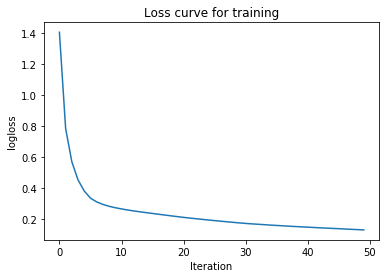

In [164]:
nn.plot_loss()

In [165]:
train_pred = nn.predict(X_train)
test_pred = nn.predict(X_test)

print("Train accuracy is: {}%".format(nn.acc(Y_train, train_pred)))
print("Test accuracy is: {}%".format(nn.acc(Y_test, test_pred)))

Train accuracy is: 93%
Test accuracy is: 70%


## Verifying with sklearn library

In [166]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

sknet = MLPClassifier(hidden_layer_sizes=(8), learning_rate_init=0.01, max_iter=100)

In [167]:
sknet.fit(X_train, Y_train)
preds_train = sknet.predict(X_train)
preds_test = sknet.predict(X_test)

print("Train accuracy of sklearn neural network: {}".format(round(accuracy_score(preds_train, Y_train),2)*100))
print("Test accuracy of sklearn neural network: {}".format(round(accuracy_score(preds_test, Y_test),2)*100))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy of sklearn neural network: 91.0
Test accuracy of sklearn neural network: 74.0


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Verifying with Keras

In [168]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [169]:
model = Sequential()
model.add(Dense(8, input_shape=(13,)))
model.add(Dense(1, activation='sigmoid'))

W0728 18:02:22.832423  5424 deprecation.py:506] From C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [170]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

W0728 18:02:23.505878  5424 deprecation.py:323] From C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [173]:
model.fit(X_train, Y_train, epochs=100, verbose=0)
train_acc = model.evaluate(X_train, Y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, Y_test, verbose=0)[1]

print("Train accuracy of keras neural network: {}".format(round((train_acc * 100), 2)))
print("Test accuracy of keras neural network: {}".format(round((test_acc * 100),2)))

Train accuracy of keras neural network: 88.89
Test accuracy of keras neural network: 75.93
